<a href="https://colab.research.google.com/github/sravanisasu/BERT_Regression/blob/main/CNN_10K.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**git clone dataset**

In [1]:
!git clone https://github.com/sravanisasu/10k-sample

Cloning into '10k-sample'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 9557 (delta 1), reused 1 (delta 0), pack-reused 9548
Receiving objects: 100% (9557/9557), 158.15 MiB | 20.28 MiB/s, done.
Resolving deltas: 100% (336/336), done.
Checking out files: 100% (10020/10020), done.


**required imports**

In [3]:
# Importing the required packages

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import numpy as np
from numpy import random
from pickle import load
from numpy import array
import os
import re
import pandas as pd
import tensorflow as tf
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras import optimizers
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.metrics import RootMeanSquaredError
import matplotlib.pyplot as plt
from keras.layers.advanced_activations import LeakyReLU

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**building embedding for the words**

In [4]:
#Define file paths required for the model

# embedding bin file
embed_file = "/content/sim.expand.200d.vec"

#Define Hyper parameters
max_inp_len = 20000
# the dimension of vectors to be used
embed_dim = 200
rounding = 6
# filter sizes of the different conv layers 
filter_sizes = [3,4,5]
num_filters = 1
pool_size = 199
# dropout probability
drop = 0.5
batch_size = 50
learning_rate = 0.001
epochs = 30

In [5]:
#define embedding dictionary and embed matrix for the vocabulary
embeddings_dic = dict()
f = open(embed_file,encoding='utf8')
with open(embed_file, 'r', encoding='utf-8') as e_file:
  for line in e_file:
    splitlines = line.split()
    word = splitlines[0].strip()
    coefs = np.asarray(splitlines[1:], dtype='float32')
    embeddings_dic[word] = coefs

print("length of embedding dictionary",len(embeddings_dic))

length of embedding dictionary 70429


In [6]:
vocabulary_size = len(embeddings_dic.keys())
embed_token = Tokenizer()
embed_token.fit_on_texts(embeddings_dic.keys())
embedding_matrix = np.zeros((vocabulary_size, embed_dim))
for word, index in embed_token.word_index.items():
  embedding_matrix[index] = embeddings_dic.get(word)
print("embedding_matrix dimension",len(embedding_matrix),len(embedding_matrix[0]))
print("no of token in the tokenizer",len(embed_token.word_index) + 1)

embedding_matrix dimension 70429 200
no of token in the tokenizer 70429


**Pre processing input and output**

In [7]:
#function to pre process the document
def process_doc(path_file,embed_token) :

  #tokenizing the words 
  with open(path_file,'r', encoding='utf-8') as tok_file :
    file_words = list(tok_file)[0].split()
    
  #removing the stop words
  stop_words = set(stopwords.words('english'))
  filtered_words = []  
  for word in file_words: 
      if word not in stop_words and word.isalpha(): 
          filtered_words.append(word)

  # applying stemming using PorterStemmer

  p_stemmer = PorterStemmer()
  stem_words=[]
  for word in filtered_words:
    stem_words.append(p_stemmer.stem(word))
    
  #tokenizing the words using the embed token
  tokens=[]
  for word in stem_words:
    try:
      tokens.append(embed_token.word_index[word])
    except:
      tokens.append(1)

  if len(tokens) < max_inp_len:
    tokens.extend([0]*(max_inp_len-len(tokens)))
  else:
    tokens = tokens[:max_inp_len]
    
  return np.array(tokens)

In [8]:
#output dataset
def output_data(company_id, out_path_file):
  with open(out_path_file,'r', encoding='utf-8') as out_file :
    for line in out_file.readlines():
      if company_id == line.split()[1]:
        return line.split()[0]
  return None

In [9]:
def pre_processing(meta_file,output_file):

  with open(meta_file,'r', encoding='utf-8') as m_file :
    
    year = meta_file.split('/')[1].split('.')[0]
    dir_path = os.path.dirname(meta_file) + '/' +year+'.tok'
    data =[]

    for line in m_file.readlines():
      inp_path_file = dir_path +'/'+ line.split()[0] + '.mda'
      
      # get input tokens from the company document
      inp_tokens = process_doc(inp_path_file,embed_token)
      
      # get output value for the company
      out_values = output_data(line.split()[0],output_file)

      #insert values into the data list
      data.append({'token':inp_tokens,'value':out_values})

  return data

In [10]:
with tf.device('/device:GPU:0'):
  ######## extracting text and storing it in dataframes ########
  data_train = pre_processing('10k-sample/2007.meta.txt','10k-sample/2007.logvol.+12.txt')
  data_train.extend(pre_processing('10k-sample/2008.meta.txt','10k-sample/2008.logvol.+12.txt'))
  data_train.extend(pre_processing('10k-sample/2009.meta.txt','10k-sample/2009.logvol.+12.txt'))
  train_df = pd.DataFrame(data_train,columns=['token','value'])
  print("Length of training data",len(data_train))


  data_test = pre_processing('10k-sample/2010.meta.txt','10k-sample/2010.logvol.+12.txt')
  test_df = pd.DataFrame(data_test,columns=['token','value'])
  print("Length of testing data",len(data_test))

  print("SAMPLE INPUT TEXT AND VOLATILITY VALUES")
  print(train_df.sample(5)[['token','value']])
  print(test_df.sample(5)[['token','value']])

Length of training data 7571
Length of testing data 2439
SAMPLE INPUT TEXT AND VOLATILITY VALUES
                                                  token     value
517   [170, 79, 197, 303, 45, 124, 25, 18, 121, 1058...  -3.43272
1935  [170, 79, 197, 303, 45, 124, 25, 18, 254, 80, ...  -3.27454
962   [170, 79, 197, 303, 45, 124, 25, 18, 1007, 150...  -3.41185
3549  [170, 79, 197, 303, 45, 124, 25, 18, 181, 78, ...  -3.15414
6641  [170, 79, 197, 303, 45, 124, 25, 18, 150, 197,...  -3.11681
                                                  token     value
1040  [170, 79, 197, 303, 45, 124, 25, 18, 314, 323,...  -3.32033
1296  [170, 79, 197, 303, 45, 124, 25, 18, 61, 664, ...  -4.46956
672   [170, 79, 197, 303, 45, 124, 25, 18, 560, 837,...  -3.51787
1987  [170, 79, 197, 303, 45, 124, 25, 18, 150, 197,...  -3.90685
574   [170, 79, 197, 303, 45, 124, 25, 18, 254, 80, ...  -3.91684


In [20]:
CNN_train_input = train_df.token.values
CNN_train_output = [ float(x) for x in train_df.value.values ]
CNN_test_input = test_df.token.values
CNN_test_output = [ float(x) for x in test_df.value.values ]

In [23]:
CNN_train_output = np.array(CNN_train_output).reshape(len(CNN_train_output),1)
CNN_test_output = np.array(CNN_test_output).reshape(len(CNN_test_output),1)

**define the model**

In [26]:
def define_model(max_inp_len,vocabulary_size,embed_dim,filter_sizes,num_filters,pool_size,drop,learning_rate):
  
  # input and embedding matrix
  inputs = Input(shape=(max_inp_len,))
  embedding = Embedding(vocabulary_size, embed_dim, weights=[embedding_matrix],trainable = False)(inputs)

  custom_objects={'leaky_relu': tf.nn.leaky_relu}

  # channel 1 convolution and local max-pooling
  convolution_1 = Conv1D(filters=num_filters, kernel_size=filter_sizes[0], activation=custom_objects['leaky_relu'])(embedding)
  pool_1 = MaxPooling1D(pool_size=pool_size)(convolution_1)
  
	# channel 2 convolution and local max-pooling
  convolution_4 = Conv1D(filters=num_filters, kernel_size=filter_sizes[1], activation=custom_objects['leaky_relu'])(embedding)
  pool_2 = MaxPooling1D(pool_size=pool_size)(convolution_4)
  
  # channel 3 convolution and local max-pooling
  convolution_5 = Conv1D(filters=num_filters, kernel_size=filter_sizes[2], activation=custom_objects['leaky_relu'])(embedding)
  pool_3 = MaxPooling1D(pool_size=pool_size)(convolution_5)
  
  # merge and dropout
  merged = concatenate([pool_1,pool_2,pool_3],axis=1)
  drop_out = Dropout(drop)(merged)
  flat = Flatten()(drop_out)

  # 2 fully connected layers
  dense1 = Dense(100, activation=custom_objects['leaky_relu'])(flat)
  outputs = Dense(1, activation=custom_objects['leaky_relu'])(dense1)
  model = Model(inputs=[inputs], outputs=outputs)
    
  opt = optimizers.SGD(learning_rate=learning_rate)
  model.compile(loss='mse', optimizer=opt)

  return model

In [27]:
# define model
model = define_model(max_inp_len,vocabulary_size,embed_dim,filter_sizes,num_filters,pool_size,drop,learning_rate)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 20000)]      0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 20000, 200)   14085800    input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 19998, 1)     601         embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 19997, 1)     801         embedding_1[0][0]                
____________________________________________________________________________________________

**Fit the model**

In [28]:
from sklearn.model_selection import KFold
n_splits = 5
epochs = 15
CNN_train_input = np.stack(CNN_train_input)
with tf.device('/device:GPU:0'):
  kf = KFold(n_splits=n_splits)
  history =[]
  train_loss=[]
  vald_loss=[]
  fold = 1
  for train_index, test_index in kf.split(CNN_train_input):
    
    checkpoint_filepath = 'CNN_results/CheckPoints/CNN_checkpoint'+str(fold)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='loss',
    mode='min',
    save_best_only=True)

    train_history = model.fit(
                              CNN_train_input[train_index],
                              CNN_train_output[train_index],#output
                              epochs=epochs, #epochs
                              verbose=1,
                              callbacks=[model_checkpoint_callback]
                          )
    model_best = tf.keras.models.load_model(checkpoint_filepath)
    fold+=1
    loss_T = model_best.evaluate(CNN_train_input[train_index],CNN_train_output[train_index], verbose=0)
    loss_V = model_best.evaluate(CNN_train_input[test_index],CNN_train_output[test_index], verbose=0)
    print(loss_T,loss_V)
    train_loss.append(loss_T)
    vald_loss.append(loss_V)
    history.append(train_history)

Epoch 1/15
190/190 [==============================] - 39s 201ms/step - loss: 9.9468
INFO:tensorflow:Assets written to: CNN_results/CheckPoints/CNN_checkpoint1/assets
Epoch 2/15
190/190 [==============================] - 38s 201ms/step - loss: 1.2972
INFO:tensorflow:Assets written to: CNN_results/CheckPoints/CNN_checkpoint1/assets
Epoch 3/15
190/190 [==============================] - 38s 202ms/step - loss: 0.5410
INFO:tensorflow:Assets written to: CNN_results/CheckPoints/CNN_checkpoint1/assets
Epoch 4/15
190/190 [==============================] - 38s 201ms/step - loss: 0.4713
INFO:tensorflow:Assets written to: CNN_results/CheckPoints/CNN_checkpoint1/assets
Epoch 5/15
190/190 [==============================] - 38s 201ms/step - loss: 0.4494
INFO:tensorflow:Assets written to: CNN_results/CheckPoints/CNN_checkpoint1/assets
Epoch 6/15
190/190 [==============================] - 38s 202ms/step - loss: 0.4379
INFO:tensorflow:Assets written to: CNN_results/CheckPoints/CNN_checkpoint1/assets
Epoc

**Plotting**

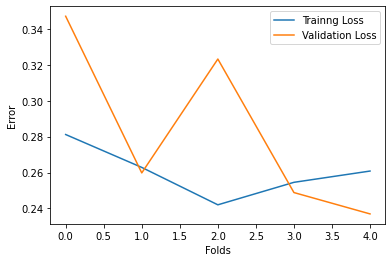

In [30]:
plt.plot(train_loss, label = "Trainng Loss")
plt.plot(vald_loss, label = "Validation Loss")
# naming the x axis 
plt.xlabel('Folds') 
# naming the y axis 
plt.ylabel('Error') 
# function to show the plot 
plt.legend()
plt.savefig('CNN_results/Plots/CNN_loss_check.png')

In [35]:
test_loss = []
CNN_test_input = np.stack(CNN_test_input)
with tf.device('/device:GPU:0'):
  for i in range(n_splits):
    checkpoint_filepath = 'CNN_results/CheckPoints/CNN_checkpoint'+str(i+1) 
    best_model = tf.keras.models.load_model(
                                            checkpoint_filepath, custom_objects=None, compile=True, options=None
                                            )
    predicted = best_model.predict(CNN_test_input)
    
    loss_test = best_model.evaluate(CNN_test_input,CNN_test_output, verbose=0)
    print("Test Errror for the fold ",i+1," is",loss_test )
    
    
    plt.plot(predicted[0:50], label = "Predicted Values")  
    plt.plot(CNN_test_output[0:50], label = "Actual Values")
    # naming the x axis 
    plt.xlabel('Test Samples') 
    # naming the y axis 
    plt.ylabel('Output Values') 
    # function to show the plot 
    plt.legend()
    textstr = "Test Errror for the fold "+ str(i+1)+" is "+str(np.round(loss_test,3))
    plt.gcf().text(0, -0.25, textstr, fontsize=14)
    plt.savefig('CNN_results/Plots/CNN_fold'+str(i+1)+'.png',bbox_inches='tight')
    plt.clf()

    test_loss.append(loss_test)

Test Errror for the fold  1  is 0.3979030251502991
Test Errror for the fold  2  is 0.31576186418533325
Test Errror for the fold  3  is 0.27637889981269836
Test Errror for the fold  4  is 0.3131793141365051
Test Errror for the fold  5  is 0.35714778304100037


<Figure size 432x288 with 0 Axes>

Training Loss: 0.260 (0.013)
Validation Loss: 0.283 (0.044)
Test Loss: 0.332 (0.042)


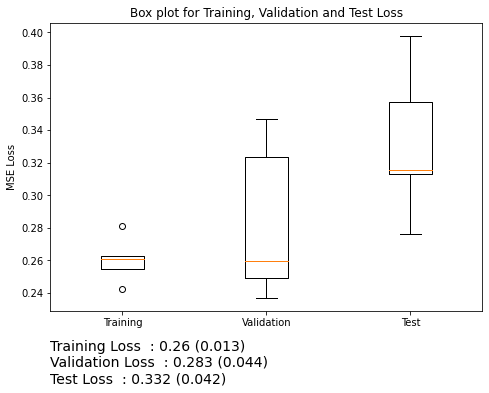

In [36]:
import matplotlib.pylab as plt
data=[]
data.append(train_loss)
data.append(vald_loss)
data.append(test_loss)
  
fig = plt.figure()  
# Creating axes instance 
ax = fig.add_axes([0, 0, 1, 1]) 
  
# Creating plot 
ax.boxplot(data)

ax.set_xticklabels(['Training', 'Validation','Test']) 

# naming the y axis 
plt.ylabel('MSE Loss')
plt.title("Box plot for Training, Validation and Test Loss")
textstr ='Training Loss  : '+str(np.round(np.mean(train_loss),3))+' ('+str(np.round(np.std(train_loss),3))+')\n'+'Validation Loss  : '+str(np.round(np.mean(vald_loss),3))+' ('+str(np.round(np.std(vald_loss),3))+')\n'+'Test Loss  : '+str(np.round(np.mean(test_loss),3))+' ('+str(np.round(np.std(test_loss),3))+')'
plt.gcf().text(0, -0.25, textstr, fontsize=14)
# show plot 
plt.savefig('CNN_results/Plots/block_CNN.png',bbox_inches='tight')

print('Training Loss: %.3f (%.3f)' % (np.mean(train_loss), np.std(train_loss)))
print('Validation Loss: %.3f (%.3f)' % (np.mean(vald_loss), np.std(vald_loss)))
print('Test Loss: %.3f (%.3f)' % (np.mean(test_loss), np.std(test_loss)))